In [1]:
display_width = 100 # in percentage

from IPython.display import display, HTML
display(HTML("<style>.container { width:"+str(display_width)+"% !important; }</style>"))

In [2]:
%reload_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from EDA import EDA_medical_appointment
from preprocessing import preprocMedicalAppointment
from feature_extraction import featuresMedicalAppointment, feature_selection_permutation_importance, feature_selection_hierarchical_clustering
from classification import LogisticRegressionClf, RandomForestClf, MLPClf, XGBClf
from utils import train_val_test_split, compare_performances_across_classifiers

2023-09-03 21:01:41.811642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 21:01:42.454028: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-03 21:01:42.454079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-03 21:01:42.454085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Read Data

In [6]:
df_medical_appointment = pd.read_csv("./data/medical_appointment_train.csv")
df_medical_appointment.rename(columns={"No-show": "no_show"}, inplace=True)
df_medical_appointment['no_show'].replace({"No": 0, "Yes": 1}, inplace=True)
feature_cols = [
    'PatientID', 'AppointmentID', 'Gender', 'ScheduledDay',
    'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
    'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received',
]
df_medical_appointment.sample(10)

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,no_show
32057,1.692272e+13,5661454,M,2016-05-05T07:30:00Z,2016-05-05T00:00:00Z,4,JABOUR,0,0,0,0,0,0,0
37289,8.945375e+14,5745090,M,2016-05-30T11:13:38Z,2016-05-31T00:00:00Z,0,FORTE SÃO JOÃO,0,0,0,0,0,0,0
26686,7.886587e+12,5713324,M,2016-05-18T09:58:57Z,2016-05-24T00:00:00Z,37,INHANGUETÁ,0,0,0,0,2,1,0
92218,2.768900e+14,5742242,M,2016-05-30T07:49:41Z,2016-06-07T00:00:00Z,0,SÃO BENEDITO,0,0,0,0,0,1,1
5999,8.222356e+13,5636492,F,2016-04-28T15:28:34Z,2016-05-02T00:00:00Z,52,JARDIM DA PENHA,0,0,0,0,0,1,1
47531,7.273436e+14,5653565,F,2016-05-03T12:38:36Z,2016-05-30T00:00:00Z,45,DE LOURDES,0,1,0,0,0,1,1
15195,1.919897e+13,5692776,F,2016-05-12T16:13:45Z,2016-05-25T00:00:00Z,29,ROMÃO,0,0,0,0,0,1,0
7230,3.496445e+13,5642817,F,2016-04-29T17:26:35Z,2016-05-19T00:00:00Z,43,NOVA PALESTINA,0,0,0,1,0,0,1
108057,7.644264e+13,5788512,F,2016-06-08T12:46:17Z,2016-06-08T00:00:00Z,22,MÁRIO CYPRESTE,0,0,0,0,0,0,0
98381,5.936947e+12,5696845,F,2016-05-13T14:26:00Z,2016-06-06T00:00:00Z,41,JABOUR,0,0,0,0,0,1,0


# Exploratory Data Analysis

In [7]:
eda = EDA_medical_appointment(df_medical_appointment[feature_cols], df_medical_appointment['no_show'])

--------------------------------------------------
Checking feature datatypes and null values
--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientID       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hypertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handicap        110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage:

None

--------------------------------------------------
Describe continuous numerical features
--------------------------------------------------


,Age
count,110527.000000
mean,37.088874
std,23.110205
min,-1.000000
25%,18.000000
50%,37.000000
75%,55.000000
max,115.000000


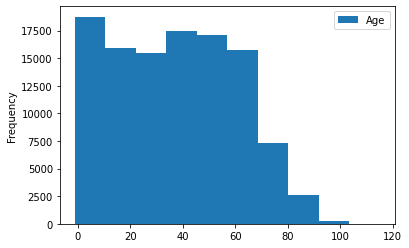

--------------------------------------------------
categorical features Probabilities
--------------------------------------------------


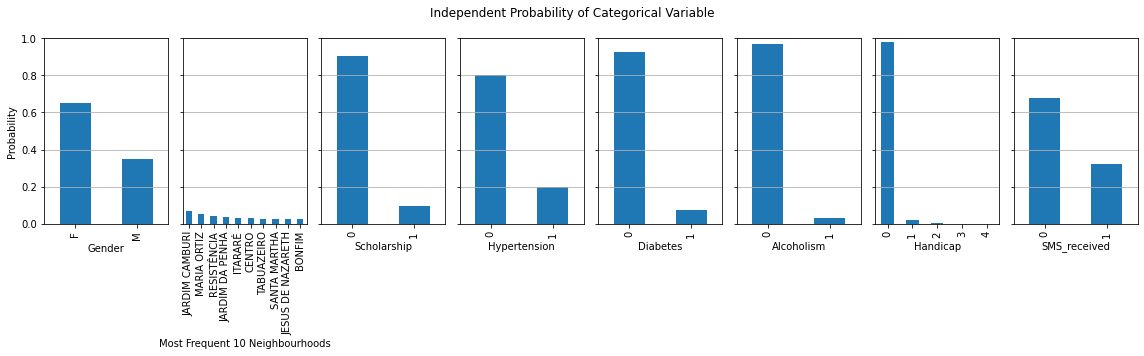

In [8]:
eda.describe_general_stats()

Min age < 0 in some cases. These are incorrect entries and for overall performance, it is desirable to remove these values from the dataset.

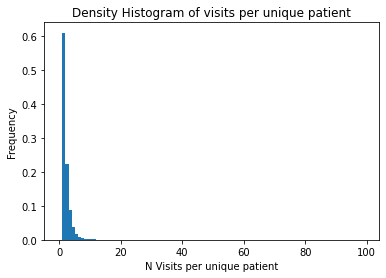

--------------------------------------------------
--------------------------------------------------
n_unique_patients = 62299
n_patients_less_than_3_visits = 51815
percent_patients_less_than_3_visits = 83%
--------------------------------------------------
--------------------------------------------------


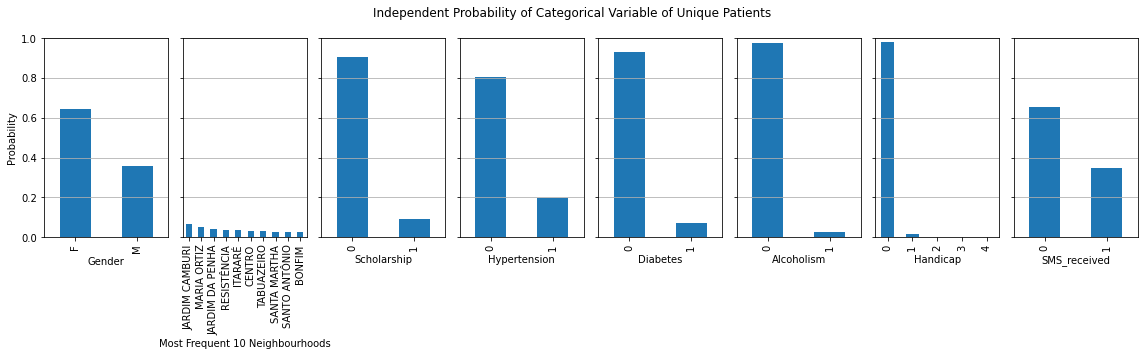

In [9]:
eda.stats_per_unique_patient()

Since, 83% of the patients visit less than 3 times, building the model primarily as a sequence classification problem is not desirable. However, a second level of sequence classification can be added to the repeat patients. This is however, not explored in this analysis.

**Conclusion:** Frame the problem as a binary classification per patient

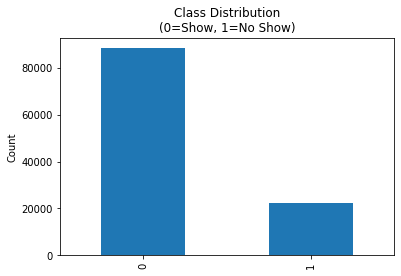

In [10]:
eda.visulaize_class_distribution()

***Conclusion***

**This is an imbalanced classification problem and techniques such as:**
1. oversampling
2. assigning class weights when performing classification
3. creating synthetic data of the imbalanced class using techniques such as SMOTE

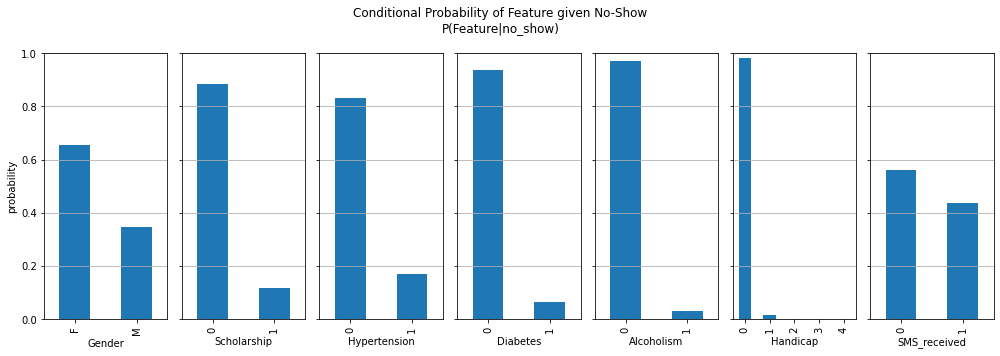

In [11]:
eda.visulaize_no_show_prob_per_variable()

***Conclusion***

**For most variables, the independent and conditional probabilities are very similar. This implies that a person not showing up for an appointment is almost independent of these categorical variables. This means that knowing one of these variables or not doesn't substantially alter the probability of a person not showing up for an appointment. However, joint probabilities are not explored in this section, and a combination of these variables occurring together may impact the outcome.**

# Preprocessing

In [12]:
preprocessor = preprocMedicalAppointment()

In [13]:
print("before", df_medical_appointment.shape)
df_medical_appointment = preprocessor.remove_outliers_age(df_medical_appointment)
print("after", df_medical_appointment.shape)

before (110527, 14)
after (110519, 14)


In [14]:
X_train, y_train, X_test, y_test, X_val, y_val = train_val_test_split(df_medical_appointment, feature_cols=feature_cols, target_col='no_show', test_percent=20)

# Feature Extraction

In [15]:
feature_extractor = featuresMedicalAppointment()

In [16]:
X_train.shape

(88415, 13)

In [17]:
scheduled_after_appointment_strategy = 'drop' # numeric or 'drop'
X_train, y_train = feature_extractor.feat_n_hours_scheduled_before(X_train, y_train, scheduled_after_appointment_strategy=scheduled_after_appointment_strategy)
X_train.shape, y_train.shape

((57665, 14), (57665,))

In [18]:
X_train = feature_extractor.feat_appointment_date(X_train)
X_train.shape

(57665, 16)

In [19]:
infrequent_threshold = 100
X_train = feature_extractor.feat_categorical_to_one_hot_encoding_train(X_train, infrequent_threshold=infrequent_threshold)
X_train.shape

Gender -> n_unique: 2
Neighbourhood -> n_unique: 71
day_of_week -> n_unique: 6


(57665, 92)

In [20]:
columns_to_scale = ['Age']
X_train = feature_extractor.feat_minmax_norm_train(X_train, columns_to_scale)
X_train.shape

(57665, 92)

In [21]:
X_train.drop(columns=['PatientID', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], inplace=True)
X_train.shape

(57665, 88)

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57665 entries, 0 to 57664
Data columns (total 88 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                57665 non-null  float64
 1   Scholarship                        57665 non-null  int64  
 2   Hypertension                       57665 non-null  int64  
 3   Diabetes                           57665 non-null  int64  
 4   Alcoholism                         57665 non-null  int64  
 5   Handicap                           57665 non-null  int64  
 6   SMS_received                       57665 non-null  int64  
 7   n_hours_scheduled_before           57665 non-null  int64  
 8   day_of_month                       57665 non-null  int64  
 9   Gender_F                           57665 non-null  int64  
 10  Gender_M                           57665 non-null  int64  
 11  Neighbourhood_ANDORINHAS           57665 non-null  int

# Feature Selection

>**Permutation Importance**

    One of the most basic questions we might ask of a model is: 
    What features have the biggest impact on predictions? This concept is called feature importance.

    In this notebook we use permutation importance. Compared to most other approaches, permutation importance is:
           - fast to calculate,
           - widely used and understood, and
           - consistent with properties we would want a feature importance measure to have.
    The basic question it answers is: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data? Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions.

>**Hierarchical clustering**

    In hierarchical clustering, we look at every pair of objects and say which two objects are the closest. We then take the closest pair, delete them, and replace them with the midpoint of the two. Then repeat that again and again. Since we are removing points and replacing them with their averages, we are gradually reducing a number of points by pairwise combining. Rather than looking at points, we look at variables and see which two variables are the most similar. In a resulting dendrogram, the vertical axis here is how similar are the two points that are being compared. If they are closer to 0, that means that they are very similar. In this case, (1 - Spearman’s R) is used. So correlation is almost exactly the same as the R², but it’s between two variables rather than a variable and its prediction.

## Feature Selection Method 1: Permutation Importance + Hierarchical Clustering

### Permutation Importance 1

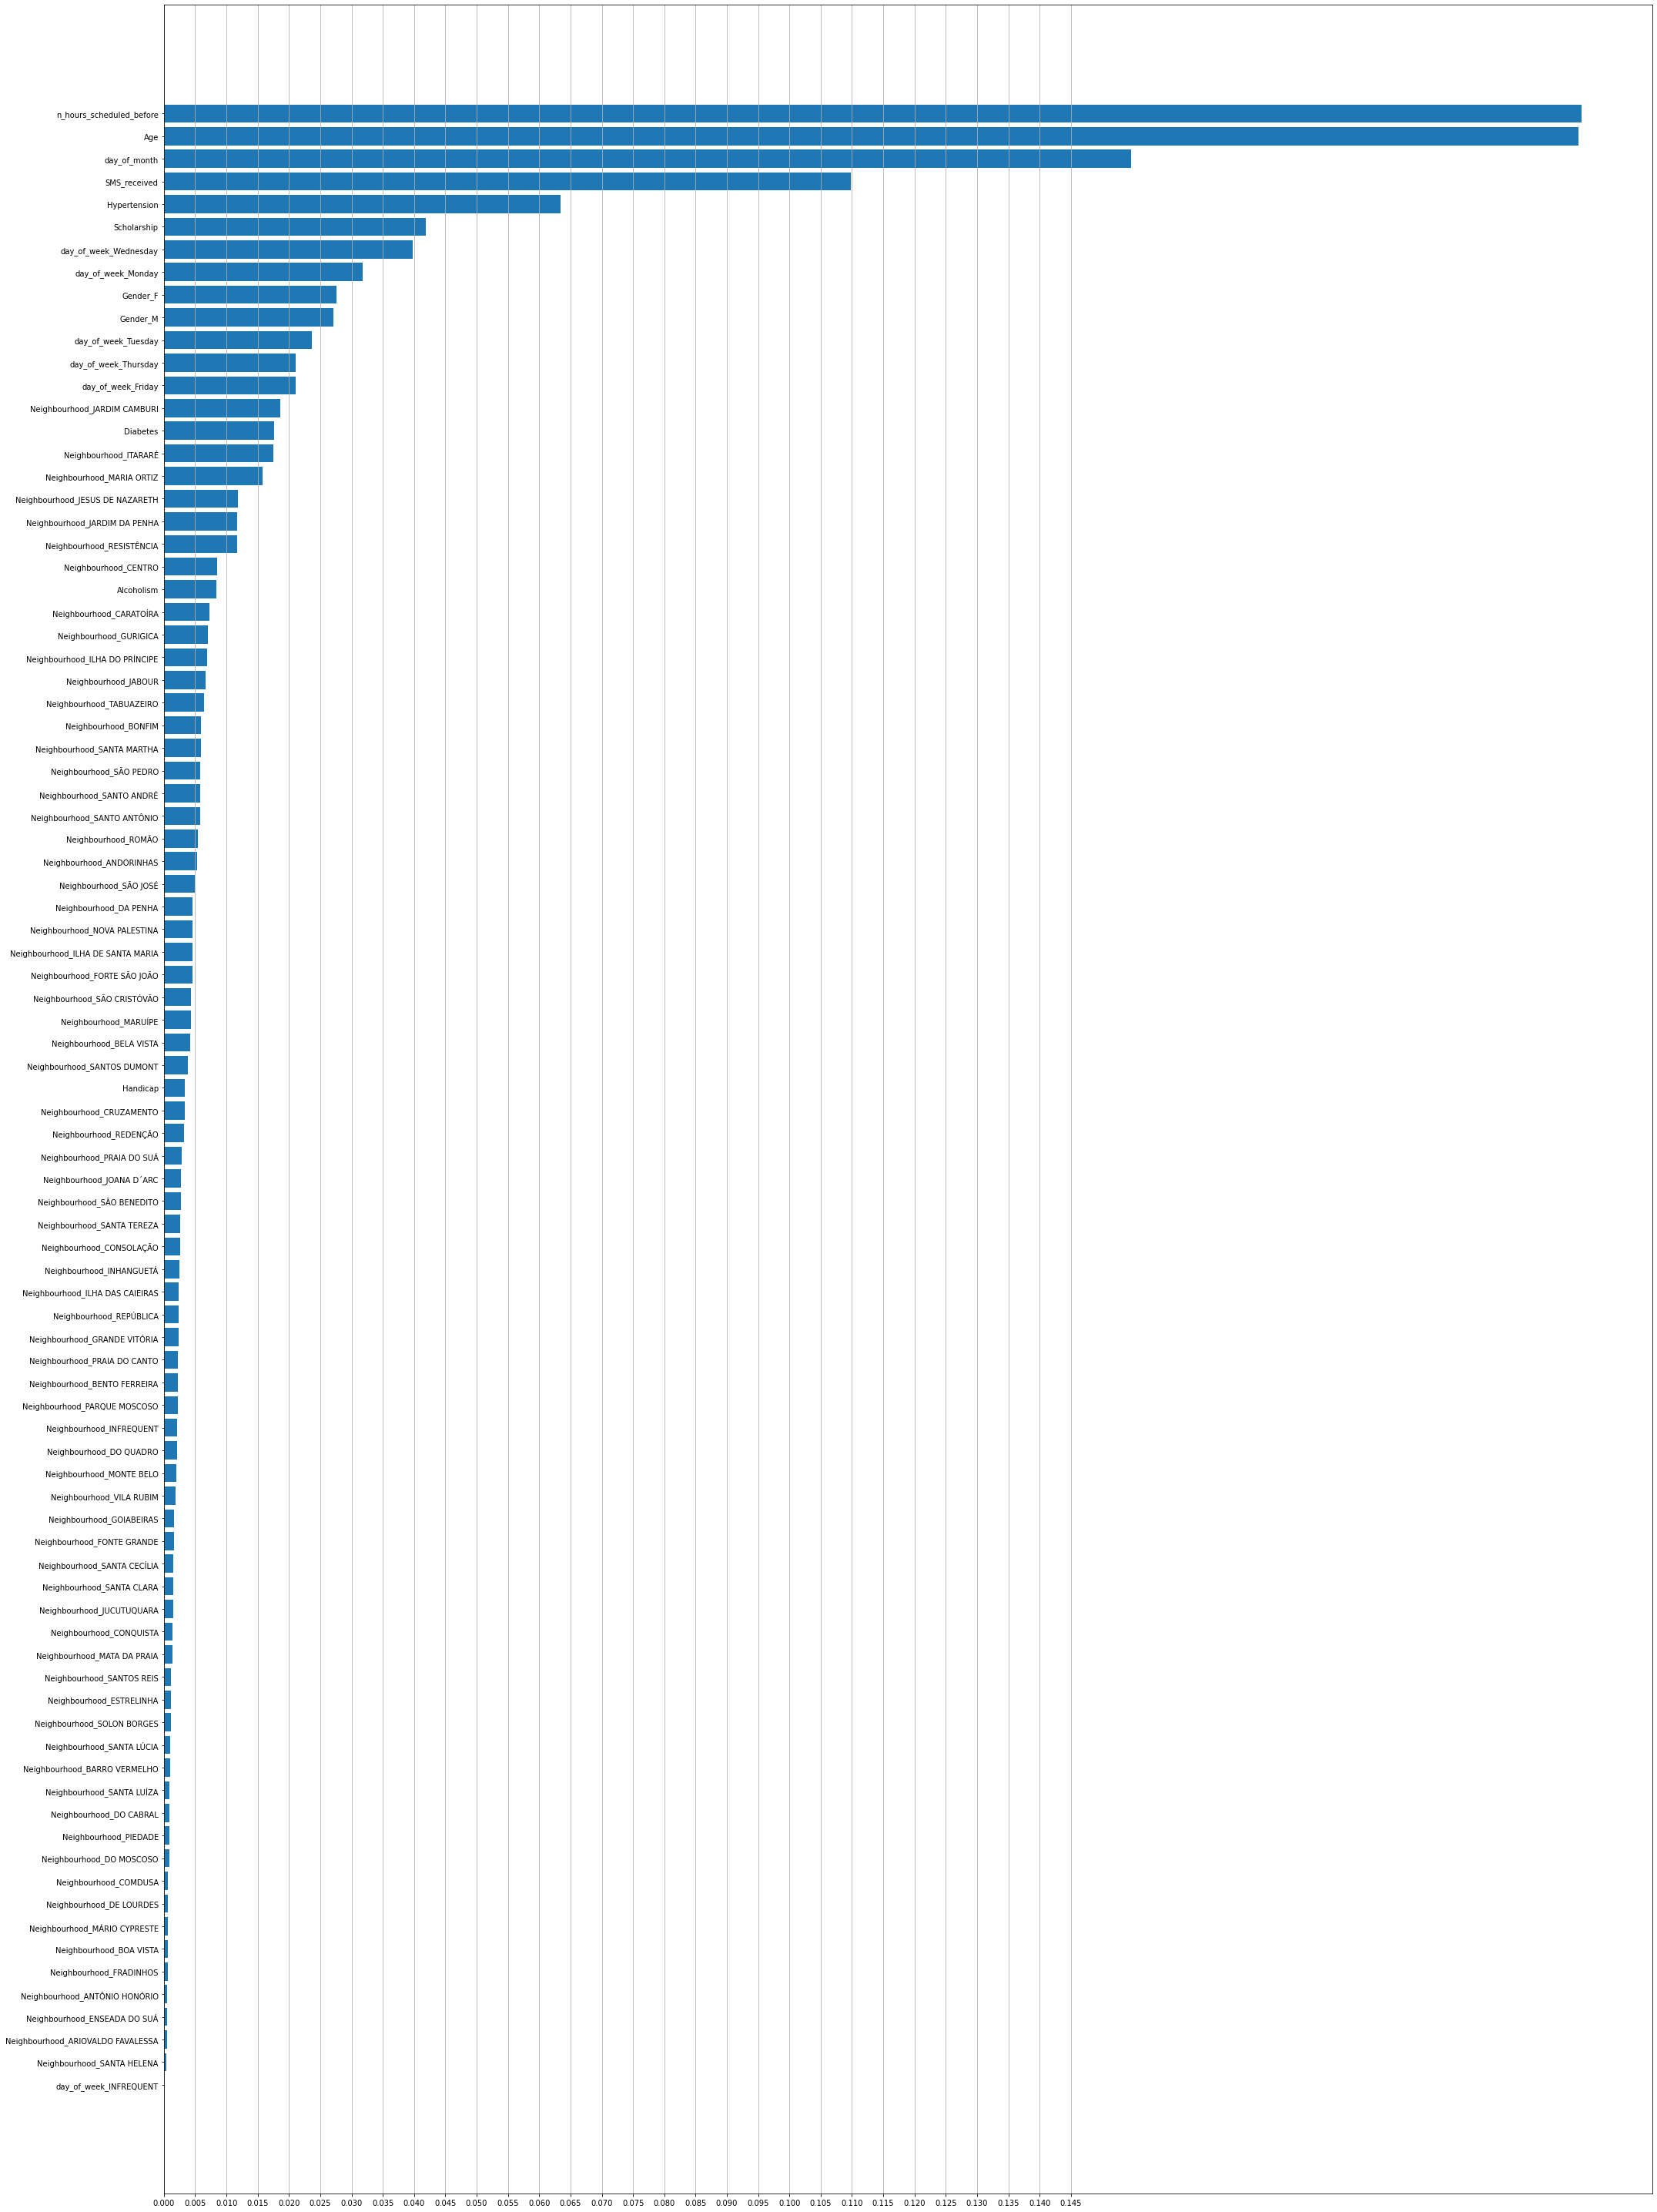

In [23]:
df_feature_importances = feature_selection_permutation_importance(
    X_train, 
    y_train, 
    n_jobs=4, 
    n_repeats=4,
    plot=True,
)

### Hierarchical Clustering 1

In [24]:
THRESHOLD_CLUSTERING = 0.75
THRESHOLD_IMPORTANCE = None # Set to None in first iteration

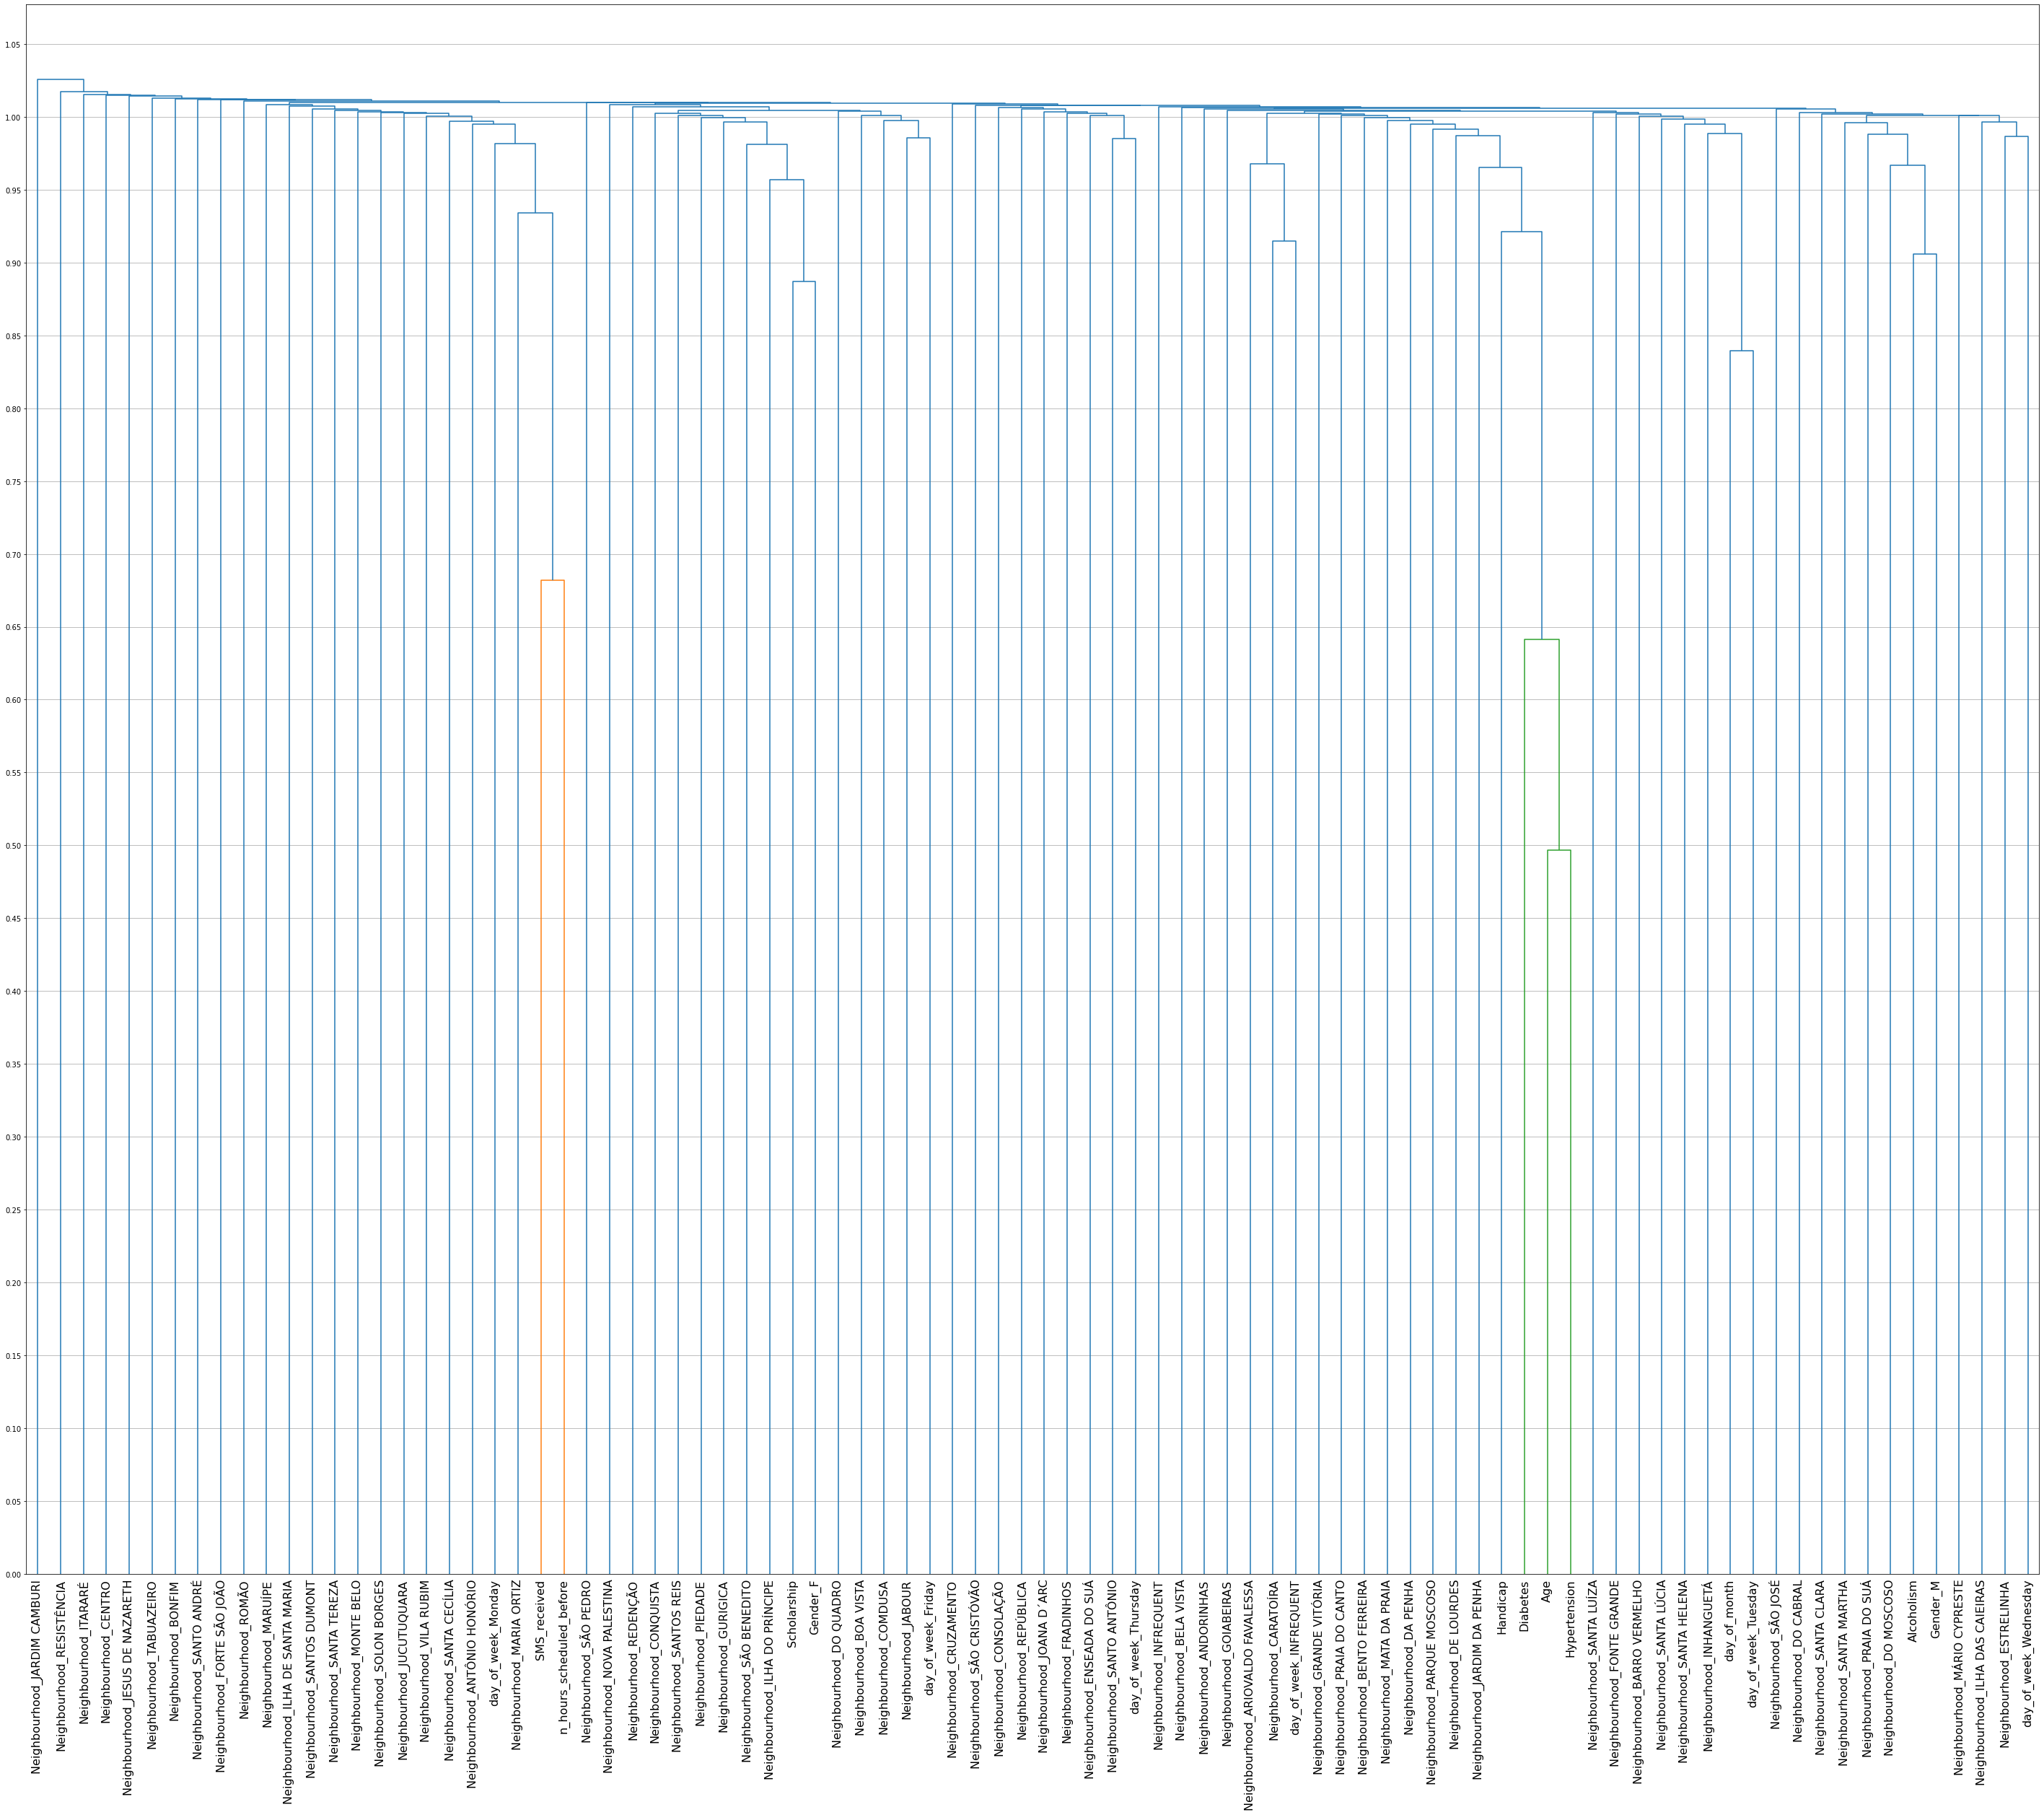

85 Selected features:
 ['Age', 'Scholarship', 'Alcoholism', 'Handicap', 'SMS_received', 'day_of_month', 'Gender_F', 'Gender_M', 'Neighbourhood_ANDORINHAS', 'Neighbourhood_ANTÔNIO HONÓRIO', 'Neighbourhood_ARIOVALDO FAVALESSA', 'Neighbourhood_BARRO VERMELHO', 'Neighbourhood_BELA VISTA', 'Neighbourhood_BENTO FERREIRA', 'Neighbourhood_BOA VISTA', 'Neighbourhood_BONFIM', 'Neighbourhood_CARATOÍRA', 'Neighbourhood_CENTRO', 'Neighbourhood_COMDUSA', 'Neighbourhood_CONQUISTA', 'Neighbourhood_CONSOLAÇÃO', 'Neighbourhood_CRUZAMENTO', 'Neighbourhood_DA PENHA', 'Neighbourhood_DE LOURDES', 'Neighbourhood_DO CABRAL', 'Neighbourhood_DO MOSCOSO', 'Neighbourhood_DO QUADRO', 'Neighbourhood_ENSEADA DO SUÁ', 'Neighbourhood_ESTRELINHA', 'Neighbourhood_FONTE GRANDE', 'Neighbourhood_FORTE SÃO JOÃO', 'Neighbourhood_FRADINHOS', 'Neighbourhood_GOIABEIRAS', 'Neighbourhood_GRANDE VITÓRIA', 'Neighbourhood_GURIGICA', 'Neighbourhood_ILHA DAS CAIEIRAS', 'Neighbourhood_ILHA DE SANTA MARIA', 'Neighbourhood_ILHA DO PRÍNCI

,coef,feature
1,0.226155,Age
2,0.154613,day_of_month
3,0.109794,SMS_received
5,0.041836,Scholarship
6,0.039786,day_of_week_Wednesday
...,...,...
83,0.000564,Neighbourhood_ANTÔNIO HONÓRIO
84,0.000546,Neighbourhood_ENSEADA DO SUÁ
85,0.000542,Neighbourhood_ARIOVALDO FAVALESSA
86,0.000434,Neighbourhood_SANTA HELENA


In [25]:
df_selected_features = feature_selection_hierarchical_clustering(
    X_train, 
    threshold_clustering=THRESHOLD_CLUSTERING, 
    threshold_importance=THRESHOLD_IMPORTANCE, 
    df_feature_importances=df_feature_importances, 
    plot=True,
)

display(df_selected_features)

In [26]:
FEATURES_PERMUTATION_IMPORTANCE_2 = df_selected_features['feature'].to_list()

### Permutation Importance 2

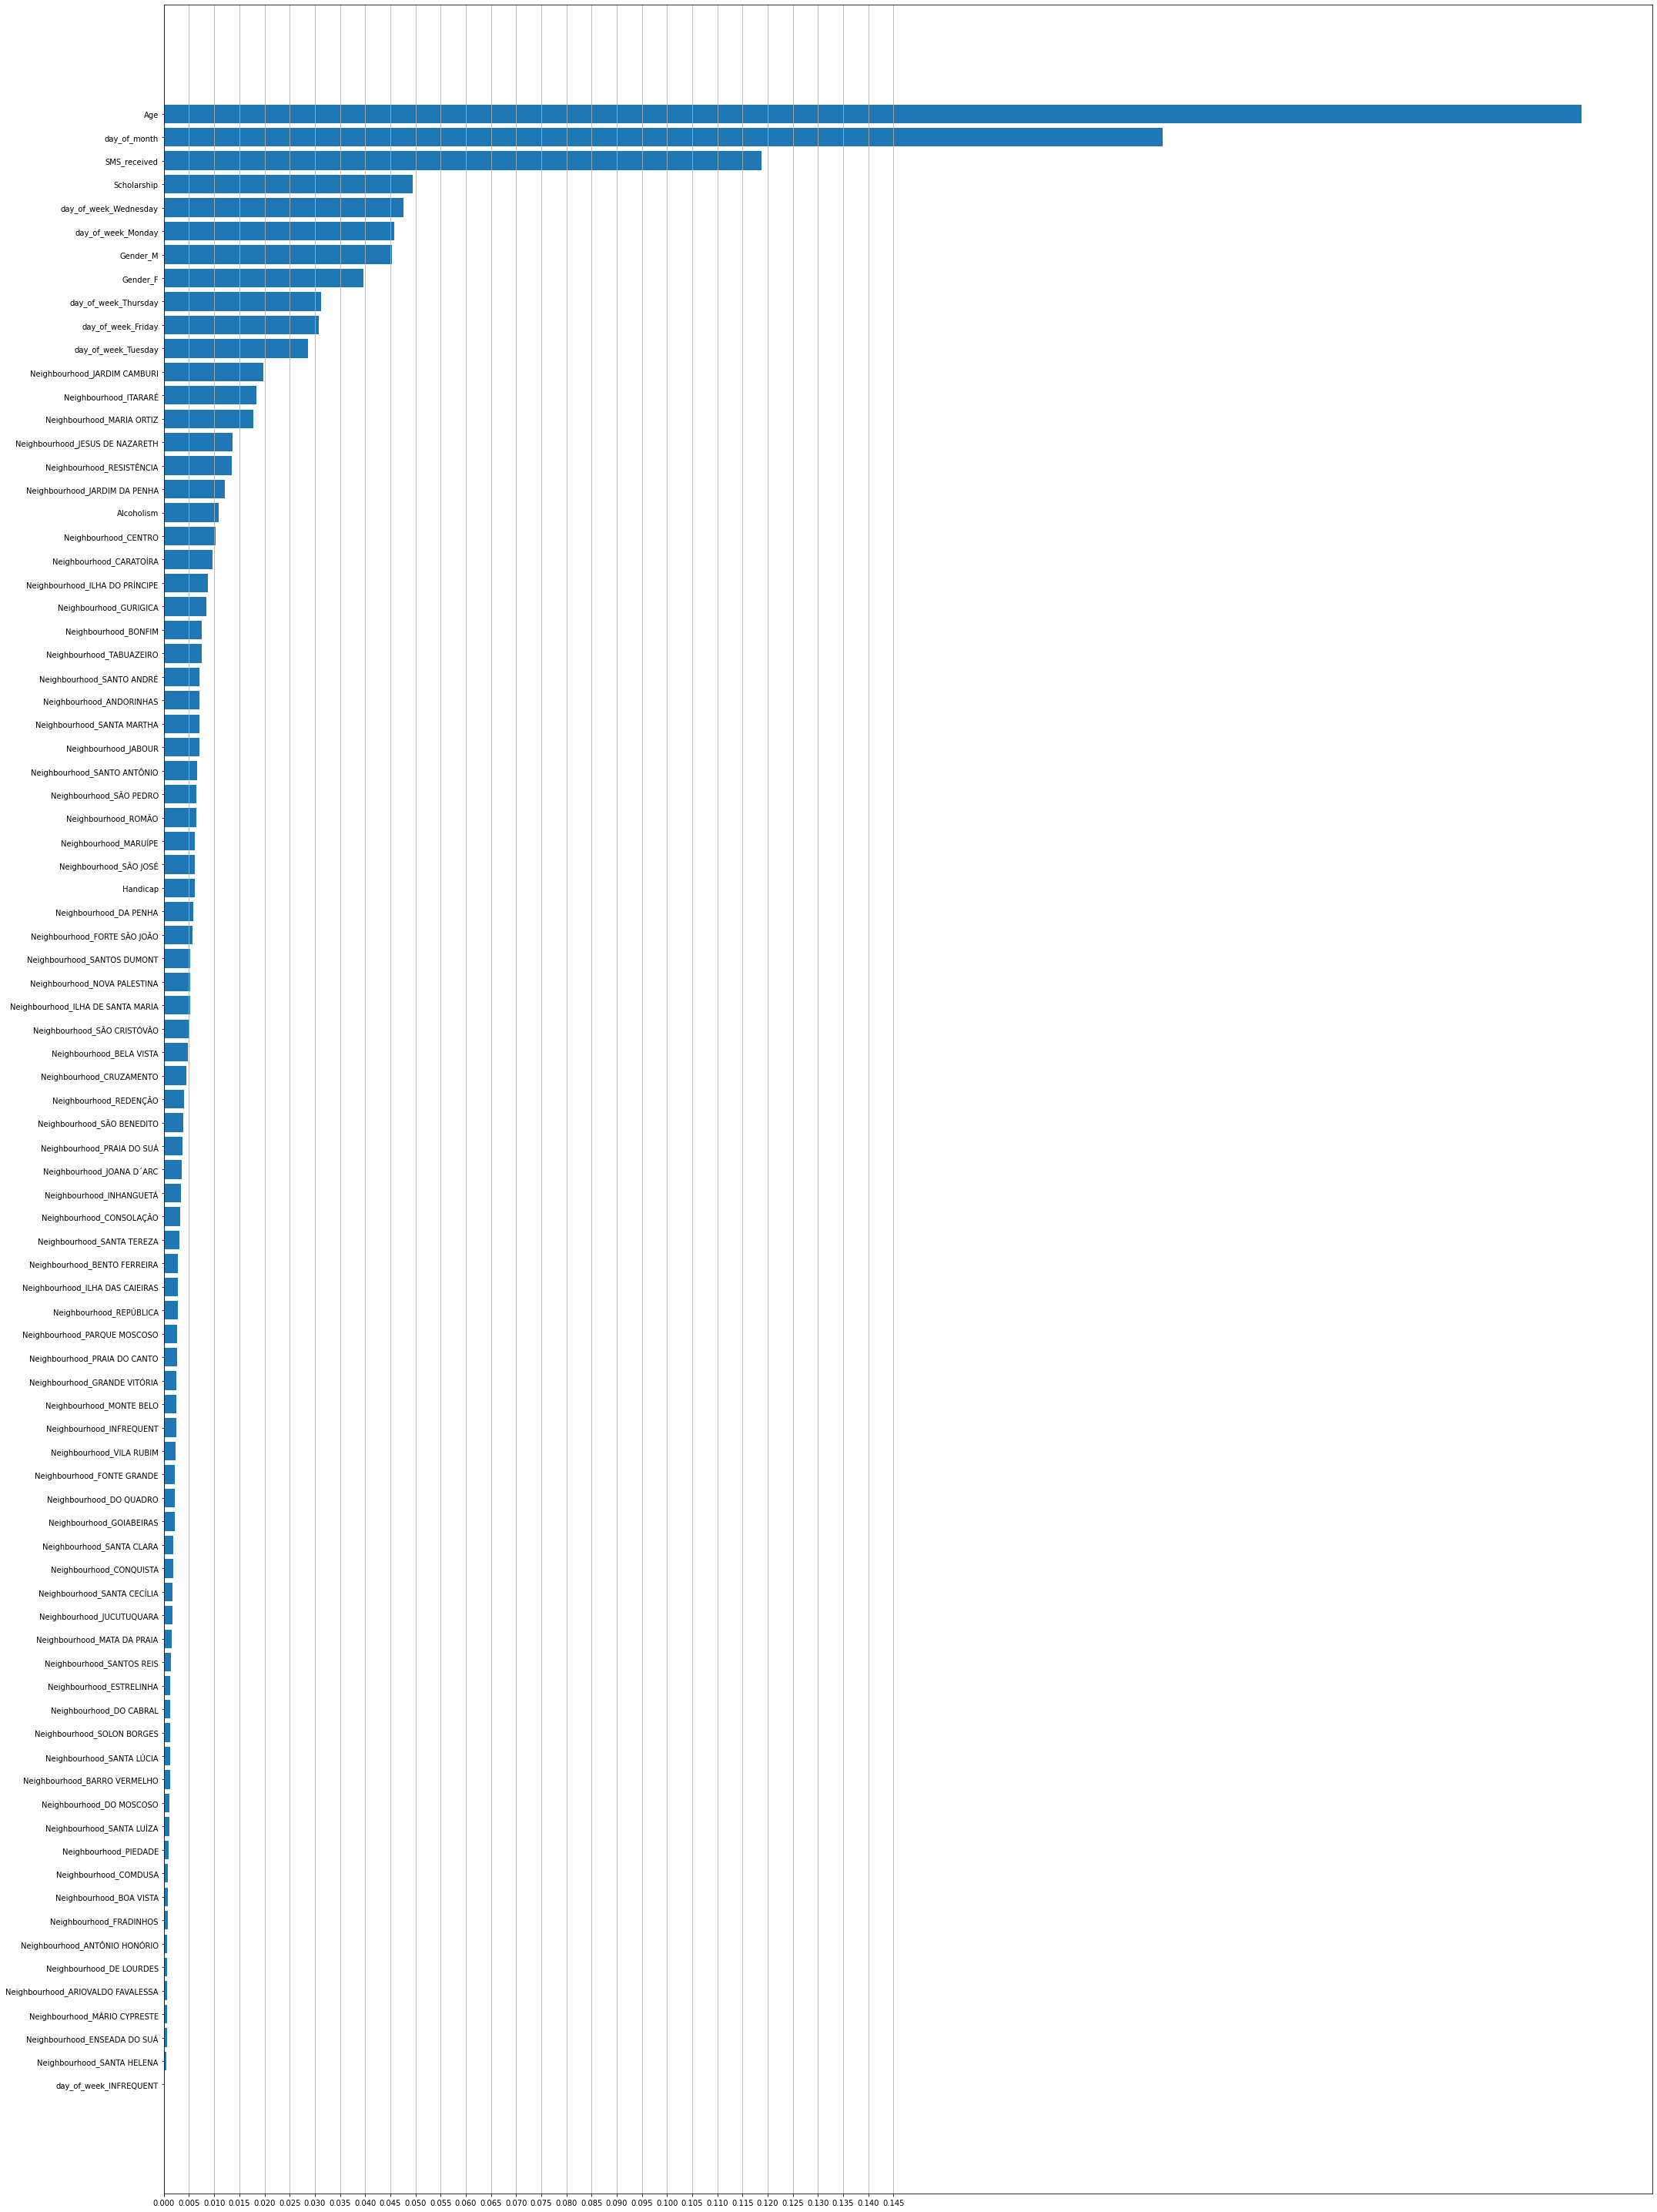

In [27]:
df_feature_importances = feature_selection_permutation_importance(
    X_train[FEATURES_PERMUTATION_IMPORTANCE_2],
    y_train,
    n_jobs=4,
    n_repeats=4,
    plot=True,
)

### Hierarchical Clustering 2

In [28]:
THRESHOLD_CLUSTERING = 0.75
THRESHOLD_IMPORTANCE = 0.005

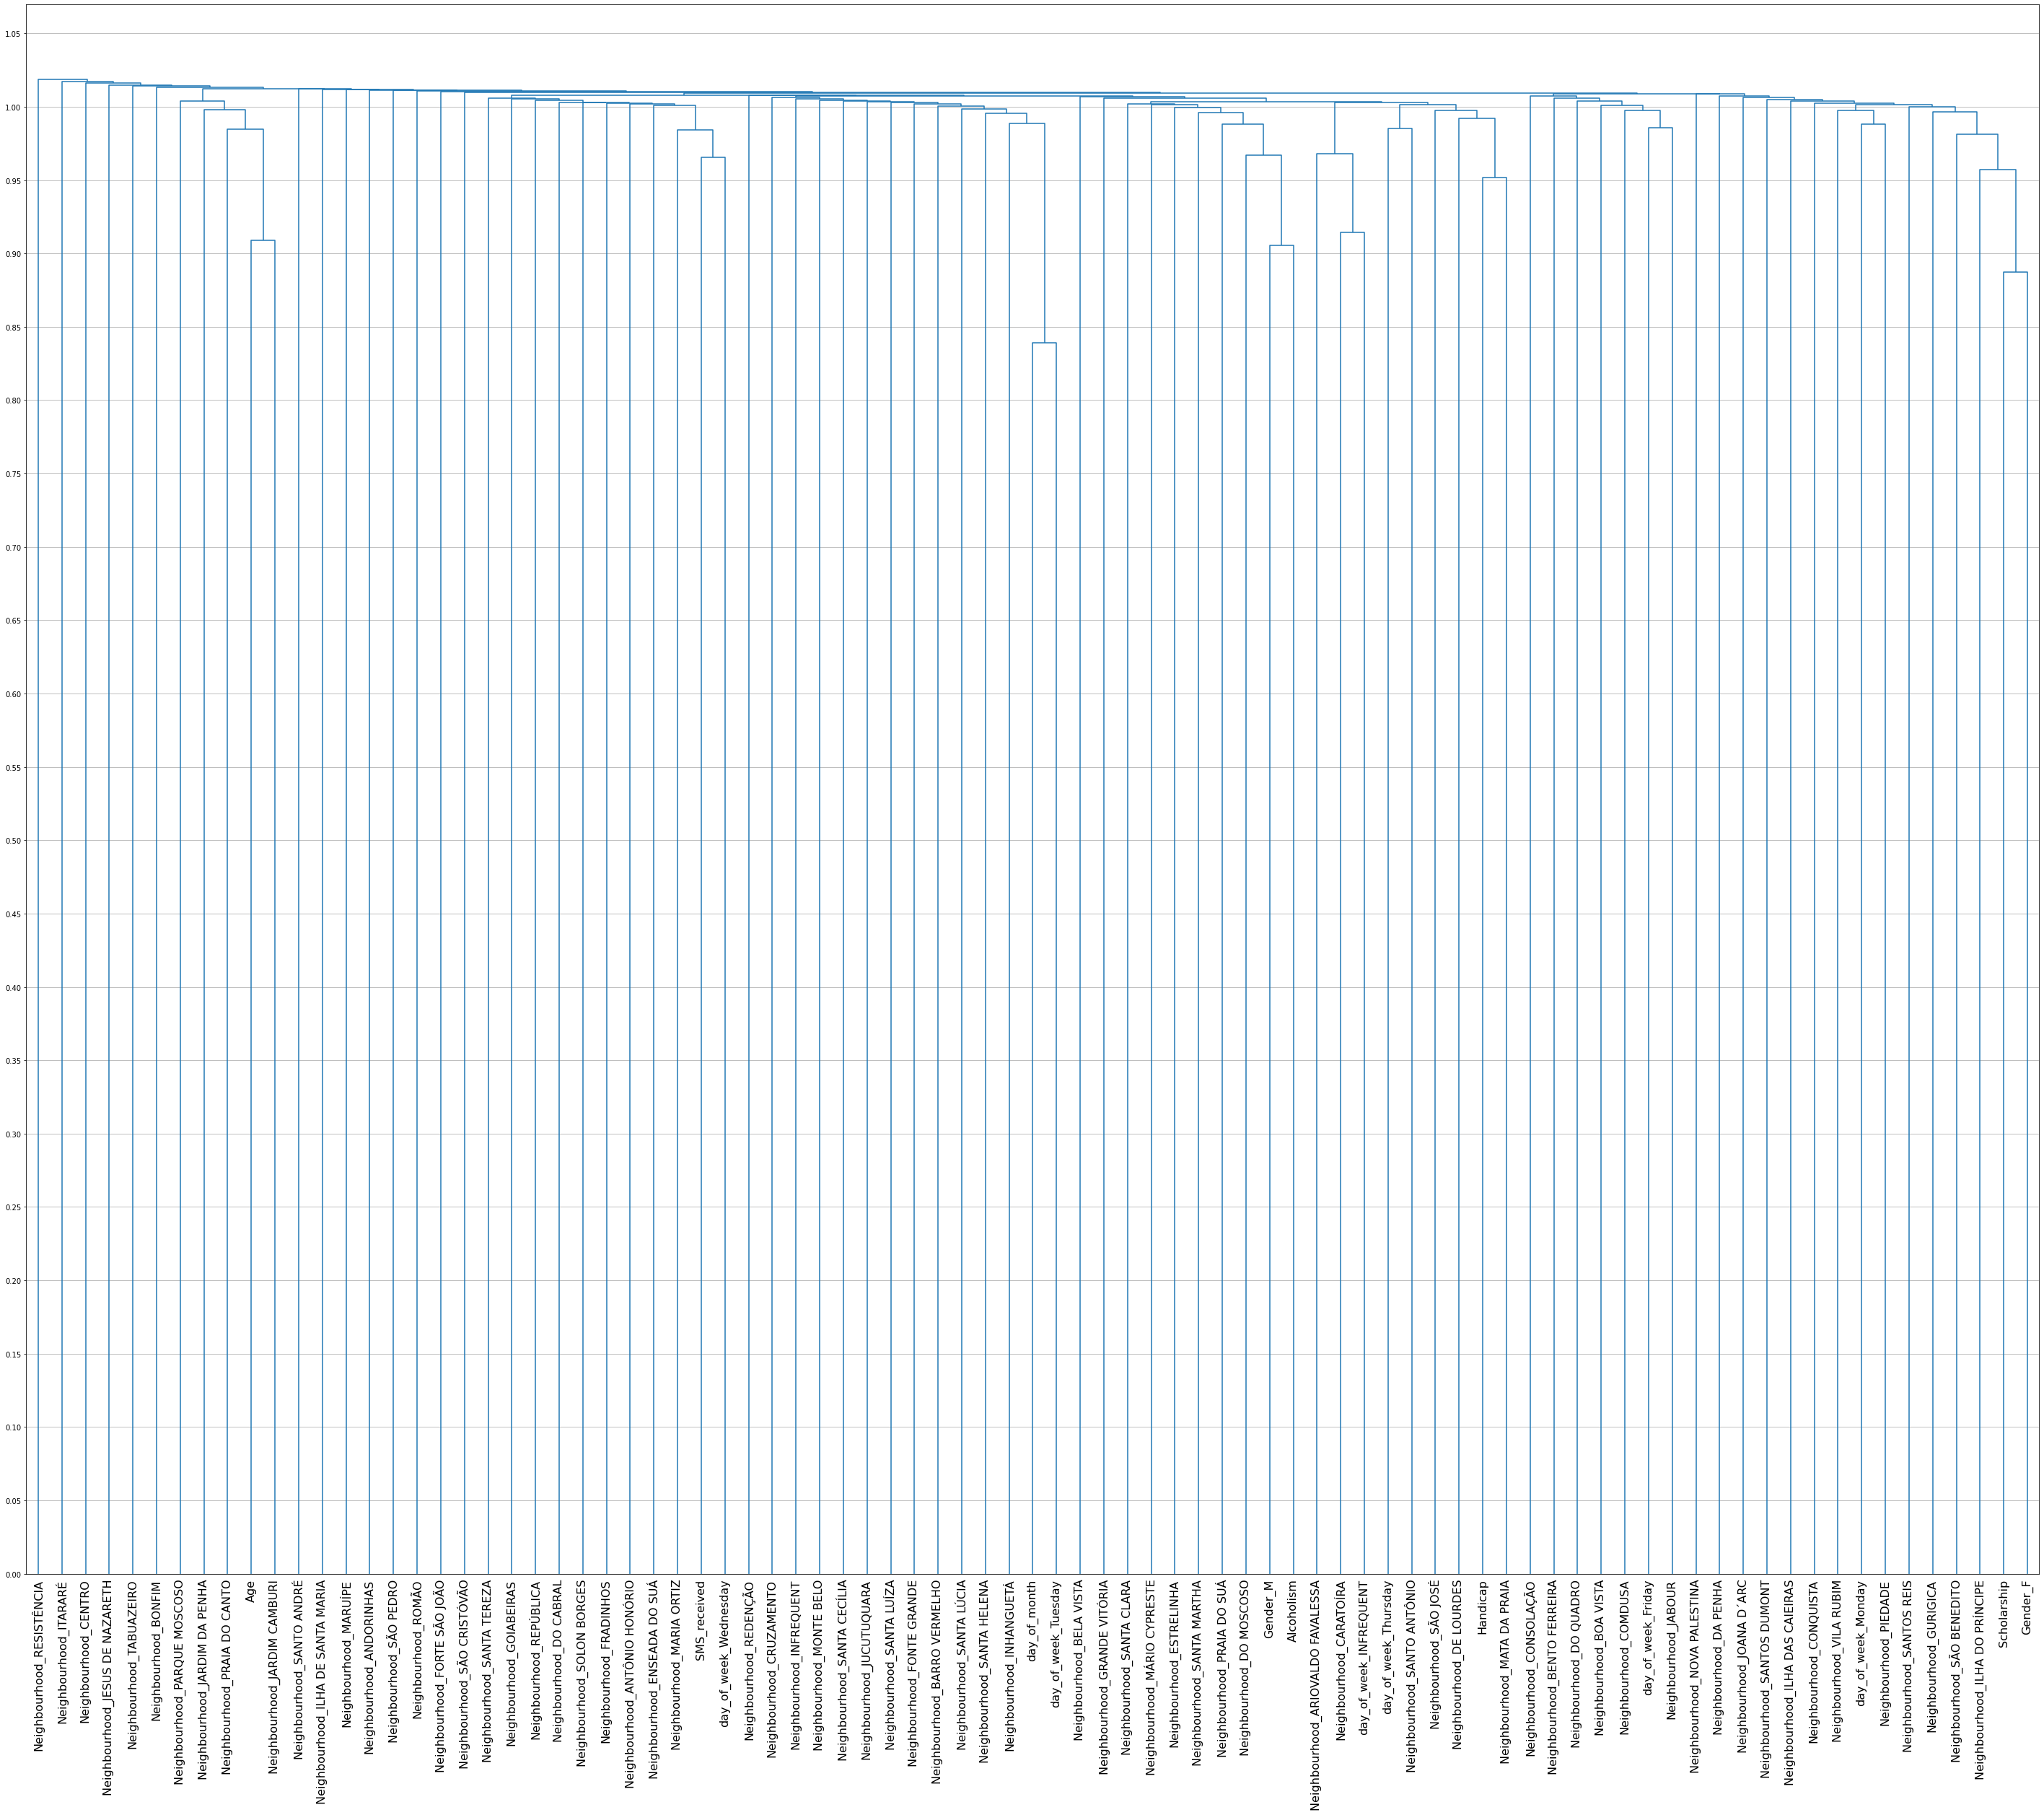

40 Selected features:
 ['Age', 'day_of_month', 'SMS_received', 'Scholarship', 'day_of_week_Wednesday', 'day_of_week_Monday', 'Gender_F', 'Gender_M', 'day_of_week_Tuesday', 'day_of_week_Thursday', 'day_of_week_Friday', 'Neighbourhood_JARDIM CAMBURI', 'Neighbourhood_ITARARÉ', 'Neighbourhood_MARIA ORTIZ', 'Neighbourhood_JESUS DE NAZARETH', 'Neighbourhood_JARDIM DA PENHA', 'Neighbourhood_RESISTÊNCIA', 'Neighbourhood_CENTRO', 'Alcoholism', 'Neighbourhood_CARATOÍRA', 'Neighbourhood_GURIGICA', 'Neighbourhood_ILHA DO PRÍNCIPE', 'Neighbourhood_JABOUR', 'Neighbourhood_TABUAZEIRO', 'Neighbourhood_BONFIM', 'Neighbourhood_SANTA MARTHA', 'Neighbourhood_SÃO PEDRO', 'Neighbourhood_SANTO ANDRÉ', 'Neighbourhood_SANTO ANTÔNIO', 'Neighbourhood_ROMÃO', 'Neighbourhood_ANDORINHAS', 'Neighbourhood_SÃO JOSÉ', 'Neighbourhood_DA PENHA', 'Neighbourhood_NOVA PALESTINA', 'Neighbourhood_ILHA DE SANTA MARIA', 'Neighbourhood_FORTE SÃO JOÃO', 'Neighbourhood_SÃO CRISTÓVÃO', 'Neighbourhood_MARUÍPE', 'Neighbourhood_BELA V

,coef,feature
0,0.281705,Age
1,0.198569,day_of_month
2,0.118716,SMS_received
3,0.049458,Scholarship
4,0.047668,day_of_week_Wednesday
5,0.045842,day_of_week_Monday
6,0.045318,Gender_M
7,0.039604,Gender_F
8,0.031223,day_of_week_Thursday
9,0.030807,day_of_week_Friday


In [29]:
df_selected_features = feature_selection_hierarchical_clustering(
    X_train[FEATURES_PERMUTATION_IMPORTANCE_2], 
    threshold_clustering=THRESHOLD_CLUSTERING, 
    threshold_importance=THRESHOLD_IMPORTANCE, 
    df_feature_importances=df_feature_importances, 
    plot=True,
)

display(df_selected_features)

In [30]:
FEATURES_LIST_PI_HC = df_selected_features['feature'].to_list()
len(FEATURES_LIST_PI_HC)

40

## Feature Selection Method 2: Principal Components Analysis

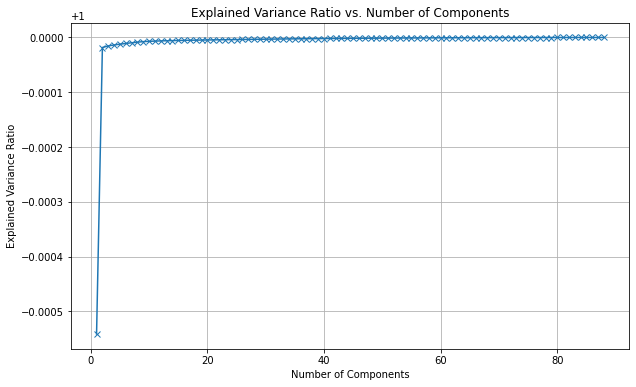

In [31]:
feature_extractor.plot_optimal_PCA_components(X_train)

In [32]:
# feature_extractor.feat_PCA_train(X_train, n_components=10)

The fact that one principal component explains all the variance suggests that the original features are not providing distinct and independent information. Instead, they are highly correlated or redundant with each other.

This method is not used in this analysis further.

## Select the desired feature list

In [33]:
FEATURES_LIST_SELECTED = FEATURES_LIST_PI_HC # FEATURES_LIST_PI_HC / list(X_train.columns)
print(len(FEATURES_LIST_SELECTED))

40


# Classification

In [34]:
df_metrics = pd.DataFrame()

In [35]:
X_test, y_test = feature_extractor.feat_n_hours_scheduled_before(X_test, y_test, scheduled_after_appointment_strategy=scheduled_after_appointment_strategy)
X_test = feature_extractor.feat_appointment_date(X_test)
X_test = feature_extractor.feat_categorical_to_one_hot_encoding_test(X_test)
X_test = feature_extractor.feat_minmax_norm_test(X_test, columns_to_scale)
X_test.drop(columns=['PatientID', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], inplace=True)
X_test.shape

Gender -> n_unique: 2
Neighbourhood -> n_unique: 71
day_of_week -> n_unique: 6


(14288, 88)

## Logistic Regression Classifier

starting with logistic regression because it is a good choice for establishing baseline performance. It is simple to implement and interpret, making it a straightforward benchmark for evaluating more complex models.

In [36]:
clf_logistic_regression = LogisticRegressionClf()
clf_logistic_regression.set_class_weights()
clf_logistic_regression.fit_classifier(X_train[FEATURES_LIST_SELECTED], y_train)

In [37]:
y_pred = clf_logistic_regression.predict_classifier(X_test[FEATURES_LIST_SELECTED])
precision_lr, recall_lr, f1_lr, accuracy_lr = clf_logistic_regression.evaluate_classifier(y_test, y_pred)

In [38]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "logistic_regression",
        "precision": precision_lr,
        "recall": recall_lr,
        "f1": f1_lr,
        "accuracy": accuracy_lr,
    }, index=[0])
])
df_metrics

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.8,0.000987,0.001972,0.716685


## Random Forest Classifier

Random Forest often outperforms logistic regression when dealing with complex, non-linear relationships and high-dimensional datasets. It can capture intricate patterns and interactions, providing better predictive accuracy and handling feature importance. The outputs of Random Forest can be less interpretable than logistic regression, but techniques like feature importance and partial dependence plots can help interpret Random Forest.

In [39]:
clf_rf = RandomForestClf()
clf_rf.set_class_weights()
clf_rf.fit_classifier(X_train[FEATURES_LIST_SELECTED], y_train)

In [40]:
y_pred = clf_rf.predict_classifier(X_test[FEATURES_LIST_SELECTED])
precision_rf, recall_rf, f1_rf, accuracy_rf = clf_rf.evaluate_classifier(y_test, y_pred)

In [41]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "random_forest",
        "precision": precision_rf,
        "recall": recall_rf,
        "f1": f1_rf,
        "accuracy": accuracy_rf,
    }, index=[0])
])
df_metrics

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.800000,0.000987,0.001972,0.716685
0,random_forest,0.339028,0.249815,0.287663,0.649216


### Hyperparameter Tuning

to find the optimal Random Forest params (can be done for other classifiers too, but chosen for Random Forest due to better baseline performance)

**Future Work:** ADD GRAPHS TO SHOW DIFFERENT CLASSIFIERS HYPERPARAMETER TUNING AND SEE WHAT FACTOR MAKES A DIFFERENCE

In [45]:
param_space = {
    'n_estimators': (10, 500),
    'max_depth': (50, 200),
    'min_samples_split': (2, 100),
    'min_samples_leaf': (5, 100),
    'max_features': (0.2, 1.0),
}

clf_rf.hyperparmater_tuning(X_train[FEATURES_LIST_SELECTED], y_train, param_space, n_iter=8, cv=4, n_jobs=1)

In [46]:
y_pred = clf_rf.predict_classifier(X_test[FEATURES_LIST_SELECTED])
precision_rf_best, recall_rf_best, f1_rf_best, accuracy_rf_best = clf_rf.evaluate_classifier(y_test, y_pred)

In [47]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "random_forest_HP_tuned",
        "precision": precision_rf_best,
        "recall": recall_rf_best,
        "f1": f1_rf_best,
        "accuracy": accuracy_rf_best,
    }, index=[0])
])
df_metrics

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.800000,0.000987,0.001972,0.716685
0,random_forest,0.339028,0.249815,0.287663,0.649216
0,random_forest_HP_tuned,0.500000,0.007899,0.015553,0.716475


## XGBoost Classifier

Using XGBoost because it typically outperforms Random Forest in complex tabular data tasks due to its gradient boosting approach, which combines weak learners into a strong model, offering higher predictive accuracy and robustness.

In [48]:
clf_xgb = XGBClf()
clf_xgb.fit_classifier(X_train[FEATURES_LIST_SELECTED], y_train)

In [49]:
y_pred = clf_xgb.predict_classifier(X_test[FEATURES_LIST_SELECTED])
precision_xgb, recall_xgb, f1_xgb, accuracy_xgb = clf_xgb.evaluate_classifier(y_test, y_pred)

/home/sgupta/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,precision,recall,f1,accuracy
0,0.00,0.283525,1.000000,0.441791,0.283525
1,0.05,0.283537,0.996544,0.441468,0.285064
2,0.10,0.285184,0.986423,0.442451,0.295143
3,0.15,0.290237,0.945939,0.444187,0.328807
4,0.20,0.303972,0.850160,0.447825,0.405585
5,0.25,0.324807,0.686497,0.440974,0.506509
6,0.30,0.350106,0.489509,0.408235,0.597634
7,0.35,0.378718,0.304863,0.337801,0.661114
8,0.40,0.401416,0.181930,0.250382,0.691139
9,0.45,0.411067,0.102691,0.164329,0.703877


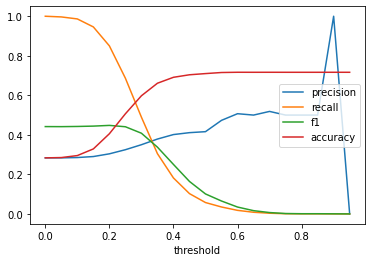

In [50]:
threshold_values = np.arange(0, 1, 0.05)
clf_xgb.predict_per_threshold(X_test[FEATURES_LIST_SELECTED], y_test, threshold_values)

In [51]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "XGBoost",
        "precision": precision_xgb,
        "recall": recall_xgb,
        "f1": f1_xgb,
        "accuracy": accuracy_xgb,
    }, index=[0])
])
df_metrics

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.800000,0.000987,0.001972,0.716685
0,random_forest,0.339028,0.249815,0.287663,0.649216
0,random_forest_HP_tuned,0.500000,0.007899,0.015553,0.716475
0,XGBoost,0.416071,0.057517,0.101063,0.709896


## MLP Classifier

Finally, trying to use a basic neural network to see if the complex relationship between the variables can be modeled well.

In [52]:
clf_mlp = MLPClf()
clf_mlp.set_class_weights()
clf_mlp.fit_classifier(X_train[FEATURES_LIST_SELECTED], y_train)

Iteration 1, loss = 0.60006357
Iteration 2, loss = 0.59236497
Iteration 3, loss = 0.58994390
Iteration 4, loss = 0.58825199
Iteration 5, loss = 0.58763137
Iteration 6, loss = 0.58577517
Iteration 7, loss = 0.58546778
Iteration 8, loss = 0.58494077
Iteration 9, loss = 0.58327495
Iteration 10, loss = 0.58207115
Iteration 11, loss = 0.58233928
Iteration 12, loss = 0.58084094
Iteration 13, loss = 0.57980005
Iteration 14, loss = 0.57935313
Iteration 15, loss = 0.57854606
Iteration 16, loss = 0.57747395
Iteration 17, loss = 0.57643069
Iteration 18, loss = 0.57577566
Iteration 19, loss = 0.57497026
Iteration 20, loss = 0.57449655
Iteration 21, loss = 0.57316709
Iteration 22, loss = 0.57290620
Iteration 23, loss = 0.57133584
Iteration 24, loss = 0.57074325
Iteration 25, loss = 0.56986696
Iteration 26, loss = 0.56924385
Iteration 27, loss = 0.56824011
Iteration 28, loss = 0.56728588
Iteration 29, loss = 0.56725449
Iteration 30, loss = 0.56584809
Iteration 31, loss = 0.56517178
Iteration 32, los

/home/sgupta/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [53]:
y_pred = clf_mlp.predict_classifier(X_test[FEATURES_LIST_SELECTED])
precision_mlp, recall_mlp, f1_mlp, accuracy_mlp = clf_mlp.evaluate_classifier(y_test, y_pred)

In [54]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "MLP",
        "precision": precision_mlp,
        "recall": recall_mlp,
        "f1": f1_mlp,
        "accuracy": accuracy_mlp,
    }, index=[0])
])
df_metrics

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.800000,0.000987,0.001972,0.716685
0,random_forest,0.339028,0.249815,0.287663,0.649216
0,random_forest_HP_tuned,0.500000,0.007899,0.015553,0.716475
0,XGBoost,0.416071,0.057517,0.101063,0.709896
0,MLP,0.367863,0.111331,0.170930,0.693799


In [55]:
y_pred = clf_mlp.predict_at_threshold(X_test[FEATURES_LIST_SELECTED], 0.4)
precision_mlp_thr_0_4, recall_mlp_thr_0_4, f1_mlp_thr_0_4, accuracy_mlp_thr_0_4 = clf_mlp.evaluate_classifier(y_test, y_pred)

In [56]:
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame({
        "classifier": "MLP_thr_0.4",
        "precision": precision_mlp_thr_0_4,
        "recall": recall_mlp_thr_0_4,
        "f1": f1_mlp_thr_0_4,
        "accuracy": accuracy_mlp_thr_0_4,
    }, index=[0])
])
df_metrics

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.800000,0.000987,0.001972,0.716685
0,random_forest,0.339028,0.249815,0.287663,0.649216
0,random_forest_HP_tuned,0.500000,0.007899,0.015553,0.716475
0,XGBoost,0.416071,0.057517,0.101063,0.709896
0,MLP,0.367863,0.111331,0.170930,0.693799
0,MLP_thr_0.4,0.362779,0.208837,0.265079,0.671683


,threshold,precision,recall,f1,accuracy
0,0.00,0.283525,1.000000,0.441791,0.283525
1,0.05,0.284918,0.959269,0.439344,0.305851
2,0.10,0.287583,0.911874,0.437263,0.334546
3,0.15,0.296633,0.837324,0.438073,0.390957
4,0.20,0.313452,0.721303,0.437000,0.473054
5,0.25,0.331760,0.572698,0.420138,0.551792
6,0.30,0.342513,0.420637,0.377576,0.606803
7,0.35,0.355718,0.299432,0.325157,0.647606
8,0.40,0.362779,0.208837,0.265079,0.671683
9,0.45,0.363095,0.150580,0.212877,0.684281


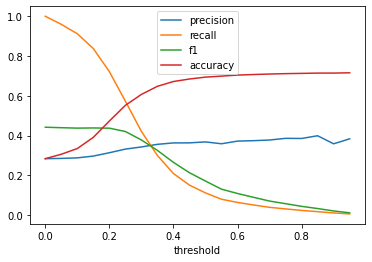

In [57]:
threshold_values = np.arange(0, 1, 0.05)
clf_mlp.predict_per_threshold(X_test[FEATURES_LIST_SELECTED], y_test, threshold_values)

## Compare Classifers

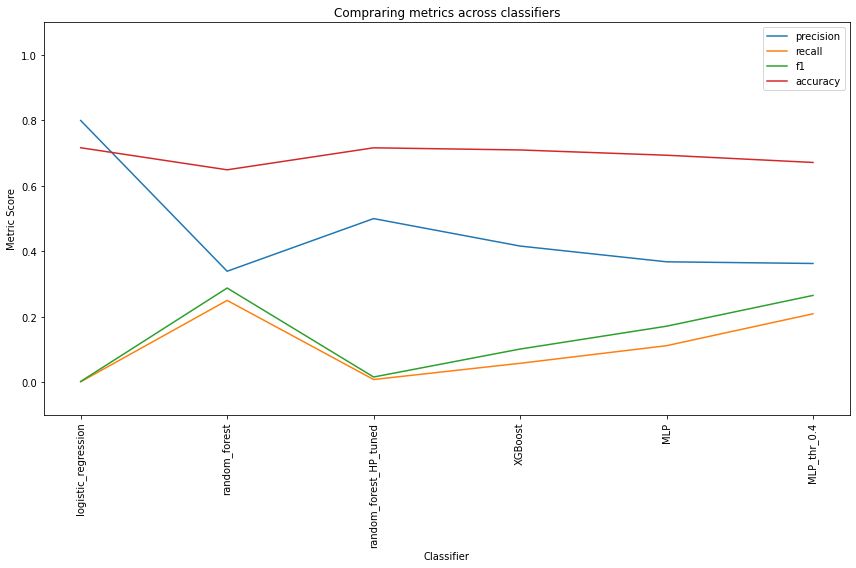

In [58]:
compare_performances_across_classifiers(df_metrics)

In [59]:
display(df_metrics)

,classifier,precision,recall,f1,accuracy
0,logistic_regression,0.800000,0.000987,0.001972,0.716685
1,random_forest,0.339028,0.249815,0.287663,0.649216
2,random_forest_HP_tuned,0.500000,0.007899,0.015553,0.716475
3,XGBoost,0.416071,0.057517,0.101063,0.709896
4,MLP,0.367863,0.111331,0.170930,0.693799
5,MLP_thr_0.4,0.362779,0.208837,0.265079,0.671683


**Discussion:**

Across all classifiers, a general trend of low recall can be observed. For an imbalanced class distribution, this an important metric to monitor (along with precision). A trend that classifiers with lower than average recall have higher precision, and vice versa can be seen. This is shows that choosing a different classification threshold is likely to shift the imbalance towards the mean (across classifiers). As a result, it can be claimed that the performance of any one classifier is not significantly better than the other.

The higher accuracy in this problem is a common red herring. And in conjunction with the low precision and recall, it can be confirmed that all the models are biased towards predicting the majority class more often.

In conclusion, the features available for classification do not model the target variable very well in this case and it can be useful to add better features or create more meaning features from the existing set.

# Error analysis

In [32]:
import giskard

In [33]:
#select a classifier from above
classifier = clf_rf

In [34]:
giskard_model = giskard.Model(
    model=classifier.predict_proba_classifier,  # A prediction function that encapsulates all the data pre-processing steps and that could be executed with the dataset used by the scan.
    model_type="classification",  # Either regression, classification or text_generation.
    name="Medical Appointment",  # Optional
    classification_labels=np.unique(y_test),  # Their order MUST be identical to the prediction_function's output order
    feature_names=FEATURES_LIST_SELECTED,  # Default: all columns of your dataset
)

giskard_dataset = giskard.Dataset(pd.concat([X_test, pd.Series(y_test, name='target')], axis=1))

# Then apply the scan
results = giskard.scan(giskard_model, giskard_dataset)

/Users/sudhanshugupta/Library/Python/3.9/lib/python/site-packages/giskard/core/dataset_validation.py:13: UserWarning: You did not provide the optional argument 'target'. 'target' is the column name in df corresponding to the actual target variable (ground truth).
  warning(


Your model is successfully validated.
🔎 Running scan…
2023-09-03 20:43:06,821 pid:62307 MainThread giskard.scanner.logger INFO     Running detectors: ['PerformanceBiasDetector', 'TextPerturbationDetector', 'EthicalBiasDetector', 'DataLeakageDetector', 'StochasticityDetector', 'OverconfidenceDetector', 'UnderconfidenceDetector', 'SpuriousCorrelationDetector']
Running detector PerformanceBiasDetector…2023-09-03 20:43:06,822 pid:62307 MainThread giskard.scanner.logger INFO     PerformanceBiasDetector: Skipping detection because the dataset has no target column.
 0 issues detected. (Took 0:00:00.000740)
Running detector TextPerturbationDetector…2023-09-03 20:43:06,824 pid:62307 MainThread giskard.scanner.logger INFO     TextPerturbationDetector: Running with transformations=['Transform to uppercase', 'Transform to lowercase', 'Transform to title case', 'Add typos', 'Punctuation Removal'] threshold=None output_sensitivity=None num_samples=None
 0 issues detected. (Took 0:00:00.000588)
Runni

Screenshot of output saved here because the interactive element was not visible when exporting the notebook.

In [ ]:
display(results)

<img src="./data/giskard_output.jpg" />